# Trabalho #2 - Rede residual e ajuste de modelo

Nesse trabalho você vai criar uma rede residual para realizar uma tarefa de classificação de múltiplas classes.

A tarefa consiste em classificar objetos do conjunto de dados CIFAR100

Esse trabalho é dividido nas seguintes etapas:

1. Explorar as imagens do conjunto de dados;
2. Construir e treinar uma rede residual para identificar o objeto mostrado na imagem;
3. Avaliar o desempenho da rede;
4. Ajustar o modelo para melhorar o desempenho.

### Importação das principais bibliotecas

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.17.1'

## 1. Conjunto de dados

O conjunto de dados CIFAR10 é composto por imagens coloridas de dimensão (32, 32, 3).

Esse conjunto de imagens é dedicado à classificçaõ multiclasse com 10 tipos de objetos.

Execute a célula abaixo para carregar o conjunto de dados CIFAR-10, que já está disponível diretamente no Keras.

In [2]:
# Importar conjunto de dados
from tensorflow.keras.datasets import cifar10

# Carregar o conjunto de dados CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Execute a célula abaixo para visualizar algumas imagens.

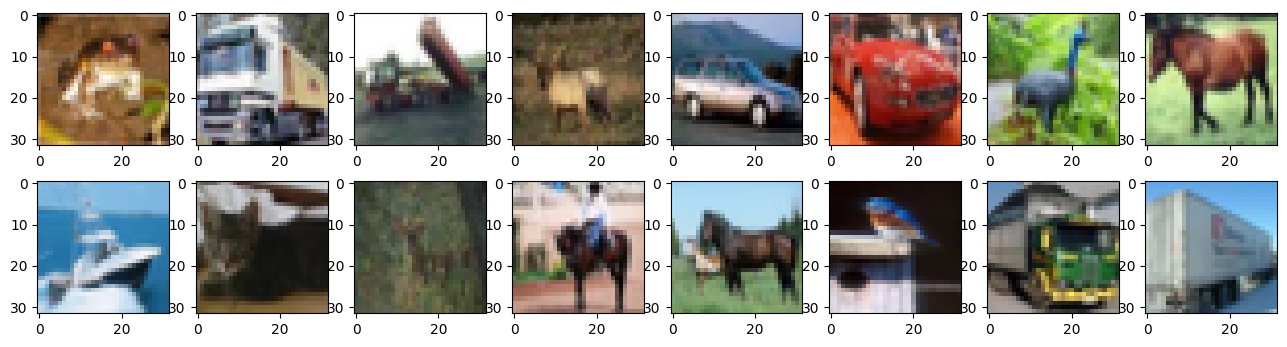

In [3]:
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
index = 0
for i in range(2):
    for j in range(8):
        axs[i,j].imshow(x_train[index])
        index += 1
plt.show()

### Exercício #1: Pré-processamento dos dados

Na célula abaixo crie um código para realizar o seguinte:

1. Normalizar as imagens de forma que os seus pixels sejam valores reais entre 0 e 1;

2. Codificação one-hot das saídas.

In [4]:
# PASRA VOCÊ FAZER: Normalização das imagens e codificação one-hot das saídas
# Importa função to_categorical
from tensorflow.keras.utils import to_categorical

# Normalização das imagens
### COMECE AQUI #### (~2 linhas)
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0
### TERMINE AQUI ###

# Converter as classes para one-hot encoding
### COMECE AQUI #### (~2 linhas)
y_train_hot = to_categorical(y_train, num_classes=10)
y_test_hot = to_categorical(y_test, num_classes=10)
### TERMINE AQUI ###

print(f"Dimensão do conjunto de treinamento: {x_train_norm.shape}")
print(f"Dimensão do conjunto de teste: {x_test_norm.shape}")
print(f"Dimensão das saídas de treinamento: {y_train_hot.shape}")
print(f"Dimensão das saídas de teste: {y_test_hot.shape}")
print('Valores máximos e mínimos das imagens de treinamento:', np.max(x_train_norm), ',', np.min(x_train_norm))
print('Valores máximos e mínimos das imagens de teste:', np.max(x_test_norm), ',',  np.min(x_test_norm))

Dimensão do conjunto de treinamento: (50000, 32, 32, 3)
Dimensão do conjunto de teste: (10000, 32, 32, 3)
Dimensão das saídas de treinamento: (50000, 10)
Dimensão das saídas de teste: (10000, 10)
Valores máximos e mínimos das imagens de treinamento: 1.0 , 0.0
Valores máximos e mínimos das imagens de teste: 1.0 , 0.0


**Saída esperada:**

    Dimensão do conjunto de treinamento: (50000, 32, 32, 3)
    Dimensão do conjunto de teste: (10000, 32, 32, 3)
    Dimensão das saídas de treinamento: (50000, 10)
    Dimensão das saídas de teste: (10000, 10)
    Valores máximos e mínimos das imagens: 1.0 0.0

## 2. Configuração do modelo

Nesse trabalho você vai criar uma rede residual com camadas densas.

Uma rede residual é composta por blocos residuais. Na Figura 1, é mostrado um bloco residual.

ASa equações que impelementam esse bloco são as seguintes:

$$a^{[l+1]} = dense(a^{[l]})$$
$$z^{[l+2]} = dense(a^{[l]})$$
$$a^{[l+2]} = g^{[l+2]}(z^{[l+2]} + a^{[l]}))$$

onde $dense$ é uma camada densa. Observe que a função de ativação da segunda camada densa do bloco somente é aplicada após a soma das ativações $a^{[l]}$ e dos estados $z^{[l+2]}$.

A camada `layers.Add()` do Keras realiza a soma de dois tensores.

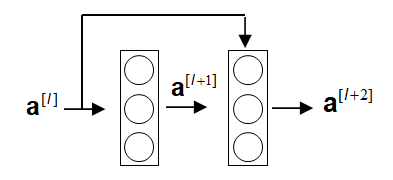

Figura 1 - Esquema de um bloco residual.

### Exercício #2: Codificação do bloco residual

Na célula abaixo crie uma função que implementa o bloco residual mostrado na Figura 1. Use a função de ativação relu.

In [6]:
### PARA VOCÊ FAZER: Definir o bloco residual
# Importa classe de camadas e modelos
from tensorflow.keras import layers, models

# Importa função de ativação
from tensorflow.keras.activations import relu

def residual_block(x, units):
    # Primeira camada densa
    ### COMECE AQUI ### (1 linha)
    z1 = layers.Dense(units, activation=relu)(x)
    ### TERMINE AQUI ###

    # Segunda camada densa sem ativação
    ### COMECE AQUI ### (1 linha)
    z2 = layers.Dense(units, activation=None)(z1)
    ### TERMINE AQUI ###

    # Soma entrada com z2 com saída da segunda camada
    ### COMECE AQUI ### (1 linha)
    added = layers.Add()([x, z2])
    ### TERMINE AQUI ###

    # Aplica função de ativação
    ### COMECE AQUI ### (1 linha)
    a2 = layers.Activation('relu')(added)
    ### TERMINE AQUI ###

    return a2

Execute a célula abaixo para testar o seu bloco residual.

In [7]:
np.random.seed(3)
x = np.random.randn(3,5)
a2 = residual_block(x, 5)
print('x:', x, '\n')
print('a2:', a2)

x: [[ 1.78862847  0.43650985  0.09649747 -1.8634927  -0.2773882 ]
 [-0.35475898 -0.08274148 -0.62700068 -0.04381817 -0.47721803]
 [-1.31386475  0.88462238  0.88131804  1.70957306  0.05003364]] 

a2: tf.Tensor(
[[1.0679691  1.1880854  0.         0.         0.42664248]
 [0.         0.34136277 0.         0.         0.        ]
 [0.         0.7346052  0.01420879 0.         0.        ]], shape=(3, 5), dtype=float32)


**Saída esperada:**

    x: [[ 1.78862847  0.43650985  0.09649747 -1.8634927  -0.2773882 ]
    [-0.35475898 -0.08274148 -0.62700068 -0.04381817 -0.47721803]
    [-1.31386475  0.88462238  0.88131804  1.70957306  0.05003364]]

    a2: tf.Tensor(
    [[1.6887243  0.5611134  0.5987834  0.         0.67116445]
    [0.         0.03314844 0.         0.1769045  0.        ]
    [0.3389045  0.16169035 0.         0.7670167  0.        ]], shape=(3, 5), dtype=float32)

### Exercício #3: Configuração da rede

A rede que será utilizada será composta por 2 blocos residuais, sendo que entre eles deve ter um camada densa para ajustar a dimensão dos dados.

Na célula abaixo crie uma função para gerar a rede residual. Essa função deve receber o seguinte:

1. Dimensão das imagens de entrada;
2. lista com número de unidades em cada bloco e cada camada da rede;
3. Número de classes para definir o número de unidades da camada de saída;
4. Exceto na camada de saída utiliza função de ativação relu;
5. Inclua camadas de dropout após cada camada densa e após cada bloco residual.

In [19]:
### PARA VOCÊ FAZER: Definir a arquitetura do modelo

def create_residual_model(n1, n2, num_classes, input_shape=(32, 32, 3)):
    ### COMECE AQUI ###
    # Camada de entrada
    inputs = layers.Input(shape=input_shape)

    # Camada para esticar a imagem (flattening)
    x = layers.Flatten()(inputs)

    # Primeira camada densa com dropout
    x = layers.Dense(n1, activation='relu')(x)
    x = layers.Dropout(0.05)(x)  # Dropout para regularização

    # Primeiro bloco residual
    x = residual_block(x, n1)
    x = layers.Dropout(0.05)(x)  # Dropout após o bloco residual

    # Camada densa intermediária para ajustar a dimensão
    x = layers.Dense(n2, activation='relu')(x)
    x = layers.Dropout(0.05)(x)  # Dropout após a camada intermediária

    # Segundo bloco residual
    x = residual_block(x, n2)
    x = layers.Dropout(0.05)(x)  # Dropout após o bloco residual

    # Camada de saída (número de classes)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Construir o modelo
    model = models.Model(inputs=inputs, outputs=outputs)
    ### TERMINE AQUI ###

    return model


Para criar o modelo, utilize a função `create_residual_model()` com os seguintes parâmetros:

- n1 = 256;
- n2 = 128;
- num_classes = 10.


In [20]:
# PARA VOCE FAZER: Criar modelo

# Definir parâmetros
### PARA VOCE FAZER ### (3 linhas)
n1 = 256
n2 = 128
num_classes = 10
### TERMINE AQUI ###

# Criar modelo
### PARA VOCE FAZER ### (1 linha)
rna = create_residual_model(n1, n2, num_classes)
### TERMINE AQUI ###

# Resumo do modelo
rna.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 3072)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 256)            │        786,688 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 256)            │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 256)            │         65,792 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 256)            │         65,792 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 256)            │              0 │ dropout_8[0][0],       │
│                           │                        │                │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 256)            │              0 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 256)            │              0 │ activation_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 128)            │         32,896 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128)            │              0 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 128)            │         16,512 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 128)            │         16,512 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 128)            │              0 │ dropout_10[0][0],      │
│                           │                        │                │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 128)            │              0 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128)            │              0 │ activation_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 10)             │          1,290 │ dropout_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 985,482 (3.76 MB)

 Trainable params: 985,482 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

**Saída esperada:**

    Model: "functional"
    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
    ┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
    ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
    │ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
    │ (InputLayer)              │                        │                │                        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ flatten_1 (Flatten)       │ (None, 3072)           │              0 │ input_layer_1[0][0]    │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_12 (Dense)          │ (None, 256)            │        786,688 │ flatten_1[0][0]        │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_13 (Dense)          │ (None, 256)            │         65,792 │ dense_12[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_14 (Dense)          │ (None, 256)            │         65,792 │ dense_13[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ add_6 (Add)               │ (None, 256)            │              0 │ dense_12[0][0],        │
    │                           │                        │                │ dense_14[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ activation_4 (Activation) │ (None, 256)            │              0 │ add_6[0][0]            │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_15 (Dense)          │ (None, 128)            │         32,896 │ activation_4[0][0]     │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_16 (Dense)          │ (None, 128)            │         16,512 │ dense_15[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_17 (Dense)          │ (None, 128)            │         16,512 │ dense_16[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ add_7 (Add)               │ (None, 128)            │              0 │ dense_15[0][0],        │
    │                           │                        │                │ dense_17[0][0]         │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ activation_5 (Activation) │ (None, 128)            │              0 │ add_7[0][0]            │
    ├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
    │ dense_18 (Dense)          │ (None, 10)             │          1,290 │ activation_5[0][0]     │
    └───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘
    Total params: 985,482 (3.76 MB)
    Trainable params: 985,482 (3.76 MB)
    Non-trainable params: 0 (0.00 B)

## 3. Compilação e treinamento do modelo

### Exercício #4: Compilação do modelo

Agora que o modelo foi criado, você precisa compilá-lo. Vamos usar a função de perda `categorical_crossentropy` para classificação multiclasse e o otimizador `Adam`.

In [21]:
# PARA VOCE FAZER: Compilar o modelo
from tensorflow.keras.optimizers import Adam
### COMECE AQUI ### (1 comando)

rna.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### TERMINE AQUI ###

### Exercício #5: Treinar o modelo

Para treinar o modelo use 100 épocas e um lote de 256 exemplos.

In [22]:
# PARA VOCE FAZER: Treinar o modelo

### COMECE AQUI ### (1 comando)

history = rna.fit(x_train_norm, y_train_hot, epochs=100, batch_size=256, validation_data=(x_test_norm, y_test_hot))

### TERMINE AQUI ###

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2216 - loss: 2.1222 - val_accuracy: 0.3584 - val_loss: 1.7977
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3549 - loss: 1.8107 - val_accuracy: 0.4064 - val_loss: 1.6714
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3853 - loss: 1.7133 - val_accuracy: 0.4202 - val_loss: 1.6280
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4109 - loss: 1.6478 - val_accuracy: 0.4471 - val_loss: 1.5649
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4259 - loss: 1.6056 - val_accuracy: 0.4520 - val_loss: 1.5329
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4459 - loss: 1.5593 - val_accuracy: 0.4646 - val_loss: 1.5050
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4583 - loss: 1.5228 - val_accuracy: 0.4675 - val_loss: 1.4939
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4606 - loss: 1.5107 - val_acc

**Saída esperada:**

    Epoch 1/100
    196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2288 - loss: 2.1627 - val_accuracy: 0.3783 - val_loss: 1.7425
    Epoch 2/100
    196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3720 - loss: 1.7419 - val_accuracy: 0.4168 - val_loss: 1.6358
    .
    .
    .
    Epoch 99/100
    196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9347 - loss: 0.1806 - val_accuracy: 0.4800 - val_loss: 4.0803
    Epoch 100/100
    196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9350 - loss: 0.1817 - val_accuracy: 0.4942 - val_loss: 4.1091

Execute a célula abaixo para vizualizar os gráficos do processo de treinamento.

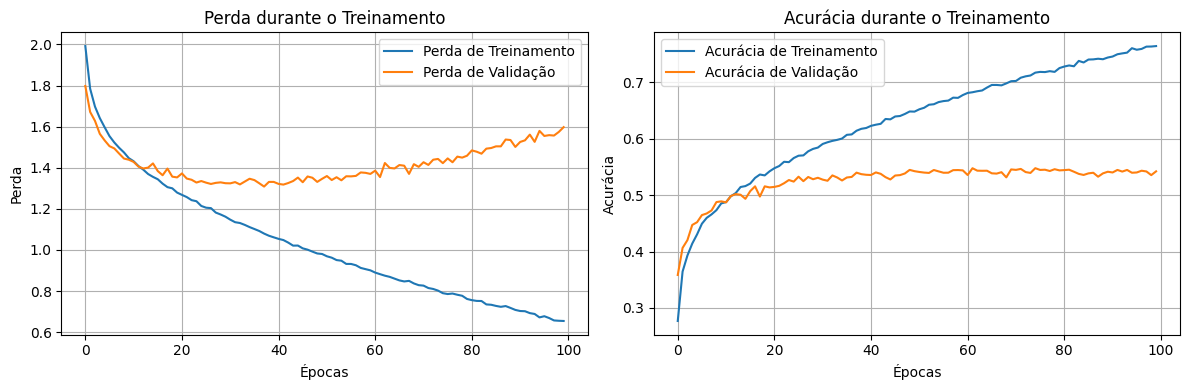

In [23]:
# Plotar a perda e acurácia durante o treinamento
plt.figure(figsize=(12, 4))

# Plotando a perda
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid()
plt.legend()

# Plotando a acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### Exercício #6: Avaliar o modelo

Use o método evaluate e calcule a função de custo e a métrica para os dados de treinamento e teste.

In [25]:
### PARA VOCE FAZER: Avaliar o modelo

### COMECE AQUI ### (2 linhas)

train_loss, train_accuracy = rna.evaluate(x_train_norm, y_train_hot, verbose=0)
test_loss, test_accuracy = rna.evaluate(x_test_norm, y_test_hot, verbose=0)

### TERMINE AQUI ###
print(f"Função de custo no conjunto de treinamento: {train_loss:.4f}")
print(f"Acurácia no conjunto de treinamento: {train_accuracy:.4f}")
print(f"Função de custo no conjunto de teste: {test_loss:.4f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")

Função de custo no conjunto de treinamento: 0.4840
Acurácia no conjunto de treinamento: 0.8343
Função de custo no conjunto de teste: 1.5975
Acurácia no conjunto de teste: 0.5422


**Saída esperada:**

    1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9438 - loss: 0.1639
    313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4957 - loss: 4.0715

## 4. Ajuste do modelo

Você agora tem um modelo básico de rede residual para classificação de imagens no conjunto CIFAR100. Por meio da adição de blocos residuais, o modelo pode ser mais profundo sem enfrentar problemas de degradação do desempenho.

Com base nesse modelo, você pode fazer experimentos adicionais para melhorar a performance, como ajustar a arquitetura, adicionar camadas de normalização, ou utilizar técnicas de data augmentation.

### Exercício #7: Ajustar o modelo para obter resultados melhores

Nesse exercício você deve fazer ajustes no modelo para melhorar o seu desempenho. As possíveis modificações são: adicionar mais blocos residuais, mudar o número de unidades nos blocos e nas camadas densas, ou tentar diferentes técnicas de regularização (dropout, L2 regularization etc.)  Além disso, é possível testar diferentes algoritmos de otimização e taxas de aprendizado.

Implemente as seguintes modificações no modelo:

1. Aumentar número de blocos residuais e aumentar número de unidades nas camadas;
2. Incluir camadas de dropout no modelo maior do item (1);
3. Retirar as camadas de dropout e aplicar regularização L2 no modelo maior do item(1).

Para cada modificação você deve apresentar o novo modelo, a compilação, o treinamento e a avaliação.

A sua avaliação nesse exercício depende dos resultados de exatidão nos dados de teste.

Analise os resultados do ajuste do modelo.

#1. Aumentar o número de blocos residuais e unidades nas camadas
Novo modelo com mais blocos e unidades:

In [26]:
def create_residual_model_v1(n1, n2, n3, num_classes, input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)

    # Bloco 1
    x = layers.Dense(n1, activation='relu')(x)
    x = residual_block(x, n1)

    # Bloco 2
    x = layers.Dense(n2, activation='relu')(x)
    x = residual_block(x, n2)

    # Bloco 3 (novo bloco)
    x = layers.Dense(n3, activation='relu')(x)
    x = residual_block(x, n3)

    # Camada de saída
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Definir parâmetros
n1, n2, n3 = 512, 256, 128  # Mais unidades e um bloco adicional
num_classes = 10

# Criar e compilar o modelo
rna_v1 = create_residual_model_v1(n1, n2, n3, num_classes)
rna_v1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history_v1 = rna_v1.fit(x_train_norm, y_train_hot, epochs=100, batch_size=256, validation_data=(x_test_norm, y_test_hot))

# Avaliar o modelo
train_loss_v1, train_accuracy_v1 = rna_v1.evaluate(x_train_norm, y_train_hot)
test_loss_v1, test_accuracy_v1 = rna_v1.evaluate(x_test_norm, y_test_hot)

print(f"Modelo v1 - Acurácia no teste: {test_accuracy_v1:.4f}")


Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.2100 - loss: 2.2413 - val_accuracy: 0.3657 - val_loss: 1.7857
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3697 - loss: 1.7477 - val_accuracy: 0.4147 - val_loss: 1.6424
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4072 - loss: 1.6539 - val_accuracy: 0.4158 - val_loss: 1.6270
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4442 - loss: 1.5544 - val_accuracy: 0.4226 - val_loss: 1.6146
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4534 - loss: 1.5232 - val_accuracy: 0.4726 - val_loss: 1.4742
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4774 - loss: 1.4619 - val_accuracy: 0.4701 - val_loss: 1.4795
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4881 - loss: 1.4307 - val_accuracy: 0.4746 - val_loss: 1.4923
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5044 - loss: 1.3852 - val_acc

#2. Incluir camadas de dropout no modelo maior
Novo modelo com dropout:

In [27]:
def create_residual_model_v2(n1, n2, n3, num_classes, input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)

    # Bloco 1 com dropout
    x = layers.Dense(n1, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = residual_block(x, n1)

    # Bloco 2 com dropout
    x = layers.Dense(n2, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = residual_block(x, n2)

    # Bloco 3 com dropout
    x = layers.Dense(n3, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = residual_block(x, n3)

    # Camada de saída
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Criar e compilar o modelo com dropout
rna_v2 = create_residual_model_v2(n1, n2, n3, num_classes)
rna_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history_v2 = rna_v2.fit(x_train_norm, y_train_hot, epochs=100, batch_size=256, validation_data=(x_test_norm, y_test_hot))

# Avaliar o modelo
train_loss_v2, train_accuracy_v2 = rna_v2.evaluate(x_train_norm, y_train_hot)
test_loss_v2, test_accuracy_v2 = rna_v2.evaluate(x_test_norm, y_test_hot)

print(f"Modelo v2 - Acurácia no teste: {test_accuracy_v2:.4f}")


Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.1567 - loss: 2.2834 - val_accuracy: 0.2768 - val_loss: 1.9227
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2738 - loss: 1.9593 - val_accuracy: 0.3289 - val_loss: 1.8546
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2937 - loss: 1.9009 - val_accuracy: 0.3151 - val_loss: 1.8740
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3117 - loss: 1.8618 - val_accuracy: 0.3636 - val_loss: 1.8081
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3210 - loss: 1.8447 - val_accuracy: 0.3706 - val_loss: 1.7755
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3353 - loss: 1.8175 - val_accuracy: 0.3759 - val_loss: 1.7764
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3397 - loss: 1.8099 - val_accuracy: 0.3702 - val_loss: 1.7823
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3386 - loss: 1.7975 - val_ac

#3. Retirar as camadas de dropout e aplicar regularização L2
Novo modelo com regularização L2:

In [28]:
from tensorflow.keras.regularizers import l2

def create_residual_model_v3(n1, n2, n3, num_classes, input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)

    # Bloco 1 com L2 regularization
    x = layers.Dense(n1, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = residual_block(x, n1)

    # Bloco 2 com L2 regularization
    x = layers.Dense(n2, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = residual_block(x, n2)

    # Bloco 3 com L2 regularization
    x = layers.Dense(n3, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = residual_block(x, n3)

    # Camada de saída
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Criar e compilar o modelo com L2 regularization
rna_v3 = create_residual_model_v3(n1, n2, n3, num_classes)
rna_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history_v3 = rna_v3.fit(x_train_norm, y_train_hot, epochs=100, batch_size=256, validation_data=(x_test_norm, y_test_hot))

# Avaliar o modelo
train_loss_v3, train_accuracy_v3 = rna_v3.evaluate(x_train_norm, y_train_hot)
test_loss_v3, test_accuracy_v3 = rna_v3.evaluate(x_test_norm, y_test_hot)

print(f"Modelo v3 - Acurácia no teste: {test_accuracy_v3:.4f}")


Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.2099 - loss: 9.0983 - val_accuracy: 0.3245 - val_loss: 2.8089
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3386 - loss: 2.5926 - val_accuracy: 0.3095 - val_loss: 2.3499
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3522 - loss: 2.1701 - val_accuracy: 0.3773 - val_loss: 2.0278
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3723 - loss: 1.9915 - val_accuracy: 0.3347 - val_loss: 2.0090
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3738 - loss: 1.9180 - val_accuracy: 0.3520 - val_loss: 1.9537
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3824 - loss: 1.8602 - val_accuracy: 0.4001 - val_loss: 1.8025
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3897 - loss: 1.8200 - val_accuracy: 0.3964 - val_loss: 1.7805
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3995 - loss: 1.7748 - val_acc

#Conclusão
O Modelo v1 foi o mais bem-sucedido devido ao aumento da capacidade de aprendizado com blocos residuais adicionais e mais unidades densas. A introdução de regularizações (v2 e v3) foi menos eficaz para este caso, pois não havia sinais claros de overfitting no modelo base.